In [39]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
print(train_y.shape)

torch.Size([100, 2])


In [48]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [56]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()


# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    print(output.covariance_matrix.shape)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

torch.Size([200, 200])
Iter 1/50 - Loss: -1.183
torch.Size([200, 200])
Iter 2/50 - Loss: -0.932
torch.Size([200, 200])
Iter 3/50 - Loss: -1.100
torch.Size([200, 200])
Iter 4/50 - Loss: -1.100
torch.Size([200, 200])
Iter 5/50 - Loss: -1.062
torch.Size([200, 200])
Iter 6/50 - Loss: -1.103
torch.Size([200, 200])
Iter 7/50 - Loss: -1.153
torch.Size([200, 200])
Iter 8/50 - Loss: -1.147
torch.Size([200, 200])
Iter 9/50 - Loss: -1.112
torch.Size([200, 200])
Iter 10/50 - Loss: -1.114
torch.Size([200, 200])
Iter 11/50 - Loss: -1.146
torch.Size([200, 200])
Iter 12/50 - Loss: -1.171
torch.Size([200, 200])
Iter 13/50 - Loss: -1.173
torch.Size([200, 200])
Iter 14/50 - Loss: -1.159
torch.Size([200, 200])
Iter 15/50 - Loss: -1.146
torch.Size([200, 200])
Iter 16/50 - Loss: -1.148
torch.Size([200, 200])
Iter 17/50 - Loss: -1.163
torch.Size([200, 200])
Iter 18/50 - Loss: -1.177
torch.Size([200, 200])
Iter 19/50 - Loss: -1.177
torch.Size([200, 200])
Iter 20/50 - Loss: -1.168
torch.Size([200, 200])
Iter 2

In [50]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42}') #' value = {param.item()}')
    print('blaaa')
    print(param)

Parameter name: likelihood.raw_task_noises                
blaaa
Parameter containing:
tensor([-4.1465, -4.0235], requires_grad=True)
Parameter name: likelihood.raw_noise                      
blaaa
Parameter containing:
tensor([-4.0866], requires_grad=True)
Parameter name: mean_module.base_means.0.constant         
blaaa
Parameter containing:
tensor([0.0057], requires_grad=True)
Parameter name: mean_module.base_means.1.constant         
blaaa
Parameter containing:
tensor([0.2767], requires_grad=True)
Parameter name: covar_module.task_covar_module.covar_factor
blaaa
Parameter containing:
tensor([[0.6163],
        [0.0476]], requires_grad=True)
Parameter name: covar_module.task_covar_module.raw_var    
blaaa
Parameter containing:
tensor([-0.8455,  0.2460], requires_grad=True)
Parameter name: covar_module.data_covar_module.raw_lengthscale
blaaa
Parameter containing:
tensor([[-1.2297]], requires_grad=True)


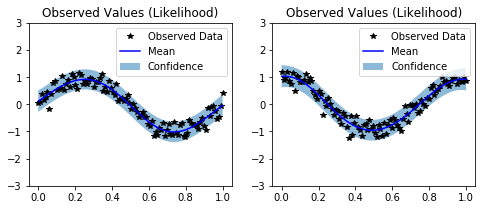

In [52]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None